In [20]:
#Fakharyar Khan and Colin Hwang
#ECE-475: Frequentist Machine Learning
#Project 5: Random Forests
#Professor Keene

#import all of the necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor

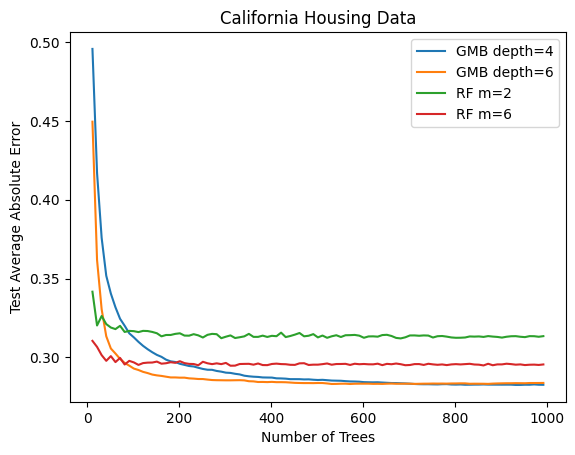

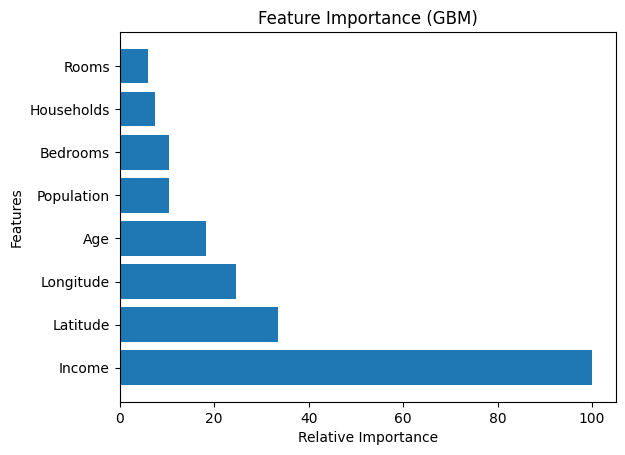

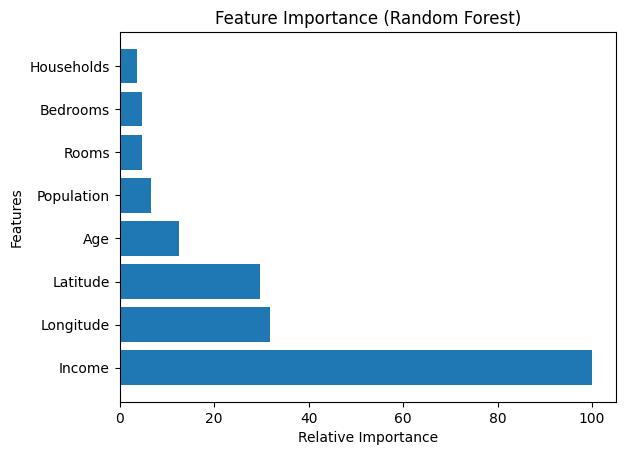

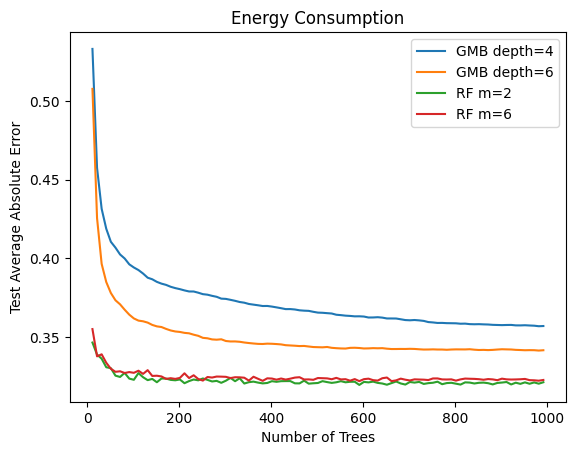

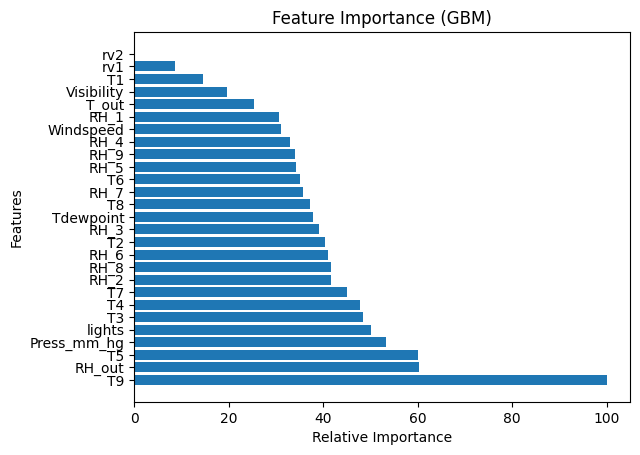

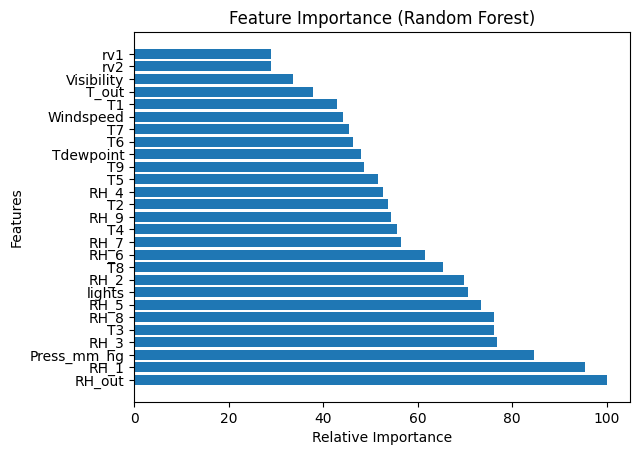

In [21]:
def run(filename, target, title):

    #read file
    df = pd.read_csv(filename)   
    labels = df[target]
    features = df.drop(target, axis = 1)
    #split dataset and normalize training and testing sets

    if(filename == "energydata_complete.csv"):
        features = features.drop("date", axis = 1)
    
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

    x_train = (x_train - x_train.mean())/x_train.std()
    x_test = (x_test - x_test.mean())/x_test.std()
    y_train = (y_train - y_train.mean())/y_train.std()
    y_test = (y_test - y_test.mean())/y_test.std()

    # replicating figure 15.3
    plt.plot(range(11, 1001, 10), plotAvgAbsError(x_train, y_train, x_test, y_test, False, 4, 0), label = "GMB depth=4")
    plt.plot(range(11, 1001, 10), plotAvgAbsError(x_train, y_train, x_test, y_test, False, 6, 0), label = "GMB depth=6")
    plt.plot(range(11, 1001, 10), plotAvgAbsError(x_train, y_train, x_test, y_test, True, 0, 2), label = "RF m=2")
    plt.plot(range(11, 1001, 10), plotAvgAbsError(x_train, y_train, x_test, y_test, True, 0, 6), label = "RF m=6")    
    plt.legend(loc = "upper right")
    plt.title(title)
    plt.xlabel("Number of Trees")
    plt.ylabel("Test Average Absolute Error")
    plt.show()

    model = xgb.XGBRegressor(n_estimators = 900, n_jobs = -1)
    model.fit(x_train, y_train)

    plotRelativeImportance(model, features, " (GBM)")

    model = RandomForestRegressor(n_estimators = 900, n_jobs = -1)
    model.fit(x_train, y_train)
    plotRelativeImportance(model, features, " (Random Forest)")

#this functions trains and tests random forest or gradient boost
#algorithms while varying the # of estimators
#takes in the training and testing sets, a boolean RF, 
#the max_depth and the maximum number of features for the model
#returns the test error for each # of estimators used
def plotAvgAbsError(x_train, y_train, x_test, y_test, RF, depth, m):
    test_error = []
    
    #if RF is false, we plot the graph for the gradient boost algorithm
    if not RF:
        for steps in range(11, 1001, 10):
            #train a model using that #of estimators
            params = {'objective': 'reg:pseudohubererror',  
                    'learning_rate': 0.1,
                    'max_leaves': 6,  
                    'n_estimators': steps, 
                    'max_depth': depth,
                    'n_jobs' : -1}
                    #"n_jobs": -1}
            xg_reg = xgb.XGBRegressor(**params) 
            #fit the model
            xg_reg.fit(x_train, y_train)
            #have it make predictions on the testing set
            predictions = xg_reg.predict(x_test)
            #calculate the error between the predictions and actual labels
            #and add to train and test error lists
            test_error.append(mean_absolute_error(predictions, y_test))

    #else we plot the graph for random forest        
    else:
        for steps in range(11, 1001, 10):
            #train a model using that #of estimators
            params = {'max_features': m, 
                    'n_estimators': steps,
                    'n_jobs' : -1}
                    # 'max_depth': depth
            rf_reg = RandomForestRegressor(**params)
            #fit the model
            rf_reg.fit(x_train, y_train)
            #have it make predictions on the testing set
            predictions = rf_reg.predict(x_test)
            #calculate the error between the predictions and actual labels
            #and add to train and test error lists
            test_error.append(mean_absolute_error(predictions, y_test))

          
    return test_error


#plots the relative importance of the features determined by the model
#takes in the model, the feature set, and the name of the title

def plotRelativeImportance(model, features, title):
    #get the relative importance of each feature determined by the model
    
    
    feat_imp = model.feature_importances_
    feat_name = features.columns
    
    #use a dataframe to sort the features by their relative importance
    data = {"Features": feat_name, "Relative Importance": 100*feat_imp/max(feat_imp)}

    data = pd.DataFrame(data)

    data = data.sort_values(by = "Relative Importance", ascending = False)
    
    #make a bar graph of the relative importance of each feature

    plt.barh(data["Features"], data["Relative Importance"])
    plt.title("Feature Importance" + title)
    plt.xlabel("Relative Importance")
    plt.ylabel("Features")
    plt.show()

run("california_housing.csv", "Housevalue", "California Housing Data")
run("energydata_complete.csv", "Appliances", "Energy Consumption")

**SUMMARY**


**Plotting of Testing Error as a Function of Number of Estimators**

We were able to obtain results that were very similar to the ones obtained in the textbook. Gradient 
boosting seems to be outperforming the random forest algorithm and whereas the random forest algorithm
appears to converge to a testing error of 0.38, even at 1000 trees, the training error for gradient
boosting still hadn't converged. Additionally, the random forest algoritxhm seems to perform better
when the maximum number of features is 6 than when it's 2. For a larger value of m, the individual
trees in the ensemble tend to be stronger models but the correlation between the trees ends up
increasing too so it seems like for this dataset, having m be slightly larger than what's recommended,
(p/3) ended up being optimal. For the gradient boosted algorithm, using a maximum depth of 6 instead
of 4 led to a smaller testing error. Increasing the depth too much could lead to overfitting
on the training set and consequently a large testing error but it seems like a depth of 6 was a more
optimal value for this dataset.


For our second dataset, we used the appliances energy prediction dataset from the UCI machine
learning repository. We found that the random forest algorithm actually outperformed the gradient 
boosting algorithm. We believe that this is due to the fast convergence of the random forest algorithm.
It only required roughly 200 estimators for its testing error to converge. If we had extended 
this graph, eventually, the gradient boosting algorithm should outperform the random forest algorithm.
It's also interesting that at around 400 estimators, the testing error for the gradient boost
algorithm actually starts to increase. Additionally, it looks like there wasn't that much difference
in performance when the maximum number of features in the random forest models was 6 or 2. This suggests
that the optimal maximum number of features is somewhere between 2 and 6.

**Plotting Relative Feature Importance for Random Forest and Gradient Boosting Models**

We found that for the california housing dataset, both models gave an almost identical
ranking for the features. The only main difference was that the random forest model
had ranked both latitude and longitude as equally important whereas gradient boosting
had given significantly more importance to latitude than longitude. We thought this 
was pretty interesting and believe that the gradient boosting models was able to 
detect a pattern in the latitude coordinates of a house that the random forest models
couldn't and that could have contributed to the gradient boosting models outperforming
the random forest models. 

Unlike the California Housing Dataset, the two models ranked the features very differently.
Both models ranked the random noise features last which is good but it looks like the 
gradient boosting model applied significantly less importance to one of the noise features
than the other which is interesting. It might be a sign that the gradient boost model was
overfitting on the training data since it was using the noise in the noise to infer
relationships that weren't there. There are also some very significant shifts in the rankings.
In the random forest model, the T5 feature is in 15th place but in the boosting model, 
it's 2nd. These changes could also be a result of our dataset have a very large number 
of features. What could have happened was that in the california dataset, there's a very
limited "chain" of patterns that a model can make so any good model would make the same
connections and come to the same conclusions. But when there are a lot more features,
like there are in this dataset, there are many different and possibly equally valid
connections that a good model could make. In that case, it might make sense why the 
random forest model outperformed the gradient boosted model. The random forest model
uses a collection of independent trees that make their own unique connections
(although the connections would be shallow) so it would have a better understanding
of the feature space. On the other hand, trees are added to the gradient boost model
by training them on the error of the model. As a result, the conclusions that the 
tree makes is dependent on the conclusions that have already been made by the model.